#### IMPORTS

In [193]:
#Importa os módulos usados

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from typing import Dict, List
import copy
import random


# Define um tipo de dado similar ao Pascal "record" or C "struct"

class Struct:
    pass

INVALID: int = -1

#### Utils de leitura do CSV

In [194]:
class Cliente:
    def __init__(self, x, y, consumo_banda):
        self.x = x
        self.y = y
        self.consumo_banda = consumo_banda
        self.connected_PA_id = INVALID
        self.id = INVALID

    def __repr__(self):
        return f"Cliente(x={self.x}, y={self.y}, consumo_banda={self.consumo_banda})"

# Função para ler os clientes do arquivo
def ler_clientes(nome_arquivo):
    clientes = []
    with open(nome_arquivo, 'r') as arquivo:
        linhas = arquivo.readlines()
        for linha in linhas:
            x, y, consumo_banda = map(float, linha.strip().split(','))
            cliente = Cliente(x, y, consumo_banda)
            clientes.append(cliente)

        index = 0
        for cliente in clientes:
            cliente.id = index
            index += 1

    return clientes

In [195]:
def clientProcessing(clientList, nCL=495, nPA=81**2):

    cons = np.zeros(nCL)
    dist = np.zeros((nCL, nPA))
    exp = np.zeros((nCL, nPA))

    cl_index = 0
    for cliente in clientList:
        cons[cl_index] = cliente.consumo_banda

        for PA_index in range(nPA):
            PA_x = (PA_index % 81) * 5
            PA_y = (PA_index // 81) * 5
            
            dist[cl_index, PA_index] = np.sqrt((cliente.x - PA_x)**2 + (cliente.y - PA_y)**2)
            exp[cl_index, PA_index] = 1/dist[cl_index, PA_index]

        cl_index += 1

    return cons, dist, exp

#### Classe Solução

In [196]:
class Solucao:
    id: int = 0
    sol_PAs_ativos: Dict[int, int] = {}
    sol_PA_id_por_cliente: Dict[int, int] = {}
    fitness_PA_min: float = 0
    fitness_PA_min_penalizado: float = 0
    penalidade: float = 0
    fitness_dist_min: float = 0
    fitness_dist_min_penalizado: float = 0
    porcentagem_CL_antendidos = 0
    nCL_por_PA: Dict[int, int] = {}

    def __init__(self) -> None:
        self.id: int = 0
        self.sol_PAs_ativos: Dict[int, int] = {}
        self.sol_PA_id_por_cliente: Dict[int, int] = {}
        self.fitness_PA_min: float = 0
        self.fitness_PA_min_penalizado: float = 0
        self.fitness_dist_min: float = 0
        self.fitness_dist_min_penalizado: float = 0
        self.porcentagem_CL_antendidos = 0
        self.nCL_por_PA: Dict[int, int] = {}

#### Dados do problema

In [197]:
class AccessPoint:
    id: int = 0
    x: int = 0
    y: int = 0
    nCL_in_range: int = 0

    def __init__(self, x: int, y: int, index: int) -> None:
        self.x = x
        self.y = y
        self.id = index
        self.nCL_in_range: int = 0
        pass

In [198]:
class ProblemData:
    PA_list: List[AccessPoint] = []
    CL_list: List[Cliente] = []
    dist_PA_CL: Dict[int, Dict[int, float]] = np.empty((81**2, 495))
    min_CL_rate: float = 0.05
    nCL: int = 495
    nPA: int = 81**2

In [199]:
def probdef(nPA=81**2, nCL=495):
    
    probdata = ProblemData()

    # Uso da função para ler os clientes do arquivo
    probdata.CL_list = ler_clientes('data/clientes.csv')

    for id in range(0, nPA):
        PA_x = (id % 81) * 5
        PA_y = (id // 81) * 5
        probdata.PA_list.append(AccessPoint(PA_x, PA_y, id))

    for PA in probdata.PA_list:
        for CL in probdata.CL_list:
            probdata.dist_PA_CL[PA.id][CL.id] = ((PA.x - CL.x)**2 + (PA.y - CL.y)**2) ** 0.5

            if(probdata.dist_PA_CL[PA.id][CL.id] <= 84):
                PA.nCL_in_range += 1
    
    probdata.PA_cap = 54 # em Mbps
    probdata.PA_raio = 84 # em metros
    probdata.CL_min_p = 0.05 # porcentagem minima de clientes
    probdata.nPA_max = 30

    return probdata

dados = probdef()

#### Solução inicial

In [200]:
def ativar_ponto_de_acesso_sol(ponto_de_acesso_id: int, clientes_sol: Dict[int, int], dados: ProblemData):
    soma_do_consumo = 0

    for cliente in dados.CL_list:
        # se o ponto ainda nao esta atendido
        cliente_nao_atendido = clientes_sol[cliente.id] == INVALID
        # se o ponto nao fara com que o ponto de acesso fique sobrecarregado com a banda necessária
        banda_suportada = (soma_do_consumo + cliente.consumo_banda) <= 54
        # se o ponto esta dentro do alcance do PA
        cliente_dentro_do_range = dados.dist_PA_CL[ponto_de_acesso_id][cliente.id] <= 70
        
        if ( cliente_nao_atendido and banda_suportada and cliente_dentro_do_range ):
            cliente.connected_PA_id = ponto_de_acesso_id
            soma_do_consumo += cliente.consumo_banda
            clientes_sol[cliente.id] = ponto_de_acesso_id


# Solução inicial
def sol_inicial():
    sol = Solucao()
    
    #  # Calcular distância euclidiana entre clientes e pontos de acesso
    # distancias = np.zeros((probdata.nCL , probdata.nPA + 1))
    # for i, CL in enumerate(probdata.CL_list):
    #     for j, PA in enumerate(probdata.PA_list):
    #         distancias[i, j] = np.sqrt((CL.x - PA.x) ** 2 + (CL.y - PA.y) ** 2)

    # # Atribuir cada cliente ao ponto de acesso mais próximo
    # for j in range(len(probdata.CL_list)):
    #     distancias_cliente = distancias[j]
    #     pa_mais_proximo = np.argmin(distancias_cliente)
    #     sol.sol_PA_id_por_cliente[j] = pa_mais_proximo  # Dá o PA mais proximo como ativo para o cliente j
    #     sol.sol_PAs_ativos[pa_mais_proximo] = 1  # Ativa o PA mais próximo

    
    for ponto_de_acesso_id in range(0, 81**2, 495):
        sol.sol_PAs_ativos[ponto_de_acesso_id] = ponto_de_acesso_id

    return sol

solucao_inicial = sol_inicial()
print(solucao_inicial.sol_PAs_ativos)

{0: 0, 495: 495, 990: 990, 1485: 1485, 1980: 1980, 2475: 2475, 2970: 2970, 3465: 3465, 3960: 3960, 4455: 4455, 4950: 4950, 5445: 5445, 5940: 5940, 6435: 6435}


#### Função Penalidades Generalizadas

In [201]:
# Função de penalidades para todas as restrições
def penalties(sol: Solucao, probdata: ProblemData):

    # percentual mínimo de clientes
    pen_CLmin = probdata.nCL * probdata.CL_min_p - np.sum(list(sol.sol_PAs_ativos.values()))
    pen_CLmin = np.sum(np.where(pen_CLmin <= 0, 0, pen_CLmin)**2)
    # print("Penalidades executadas: 1", end="")

# # limite de consumo dos PAs
    # pen_PAcap = np.zeros(probdata.nPA)
    # for i in range(probdata.nPA):
    #     #Acha a lista de id de clientes que possuem conexão ativa com o PA i
    #     CLs_ids = [k for k, v in sol.sol_PA_id_por_cliente.items() if v == i]
    #     consumo_total = 0
    #     index = 0
    #     for CL in (probdata.CL_list):
    #         if index in CLs_ids:
    #             consumo_total += CL.consumo_banda
    #         index += 1
        
    #     current_PA_ativo = 0
    #     if i in sol.sol_PAs_ativos:
    #         current_PA_ativo = 1

    #     pen_PAcap[i] = consumo_total - current_PA_ativo * probdata.PA_cap
    #     pen_PAcap[i] = np.sum(np.where(pen_PAcap[i] <= 0, 0, pen_PAcap[i])**2)
    
    # print("-2", end="")

# # limite de distância entre PAs e clientes
    # # Calcula a lista de clientes conectados para cada ponto de acesso
    # connected_clients = {i: [k for k, v in sol.sol_PA_id_por_cliente.items() if v == i] for i in range(probdata.nPA)}

    # # Pré-calcular current_PA_ativo para cada ponto de acesso
    # current_PA_ativo = {PA.id: 1 if PA.id in sol.sol_PAs_ativos else 0 for PA in probdata.PA_list}

    # # Preparar matriz para pen_dist
    # pen_dist = np.zeros((probdata.nCL, probdata.nPA))

    # # Iterar sobre os pontos de acesso e clientes conectados
    # for i, PA in enumerate(probdata.PA_list):
    #     CLs_ids = connected_clients[i]
    #     areTheyConnected = np.zeros(probdata.nCL)
    #     areTheyConnected[CLs_ids] = 1
    #     pen_dist[:, i] = probdata.dist_PA_CL[PA.id] * areTheyConnected - current_PA_ativo[PA.id] * probdata.PA_raio
    #     pen_dist[:, i] = np.sum(np.where(pen_dist[:, i] <= 0, 0, pen_dist[:, i])**2)
    # print("-3", end="")

# # pelo menos 5% de exposição à rede
    # pen_Expmin = np.zeros(probdata.nCL)
    # for i, CL in enumerate(probdata.CL_list):
    #     totalExposure: float = 0
    #     for j in sol.sol_PAs_ativos.keys():
    #         totalExposure += 1/probdata.dist_PA_CL[j, CL.id]

    #     pen_Expmin[i] = 0.05 * 1 - totalExposure
    #     pen_Expmin[i] = np.sum(np.where(pen_Expmin[i] <= 0, 0, pen_Expmin[i])**2)
    # print("-4", end="")

    # número máximo de PAs
    pen_PAmax = sum(sol.sol_PAs_ativos.values()) - probdata.nPA_max
    # print("-5")

    # return all multiplied by U
    return 1000 * (pen_CLmin + pen_PAmax )

#### Funçao Objetivo 1: Minimizar número de PAs ativos

In [202]:
# Função objetivo 1: Minimizar número de PAs ativos
def fobj_minPA(sol: Solucao, probdata: ProblemData):

    nCL_por_PA_local: Dict[int, int] = {}
    nCL_atendidos: int = 0

    # criando a posição dos clientes no dicionário com um valor padrão
    for CL in probdata.CL_list:
        nCL_por_PA_local[CL.id] = INVALID

    # ativando cada PA para a solução
    for ponto_de_acesso_id in sol.sol_PAs_ativos:
        ativar_ponto_de_acesso_sol(ponto_de_acesso_id, nCL_por_PA_local, probdata)

    # relacionando o número de PA's em relação ao número de clientes que ele atende
    sol.nCL_por_PA: Dict[int, int] = {}

    for CL in probdata.CL_list:
        if nCL_por_PA_local[CL.id] != INVALID:
            nCL_atendidos += 1
            if nCL_por_PA_local[CL.id] in sol.nCL_por_PA:
                sol.nCL_por_PA[nCL_por_PA_local[CL.id]] += 1
            else:
                sol.nCL_por_PA[nCL_por_PA_local[CL.id]] = 1
    
    sol.nCL_por_PA = nCL_por_PA_local


    sol.fitness_PA_min = len(sol.sol_PAs_ativos)
    sol.penalidade = penalties(sol, probdata)
    sol.fitness_PA_min_penalizado = sol.fitness_PA_min + sol.fitness_PA_min_penalizado
    sol.porcentagem_CL_antendidos = nCL_atendidos / 495

    return sol

#### Função Objetivo 2: Minimizar distâncias entre clientes e PAs

In [2]:
# Função objetivo 2: Minimizar distância cumulativa de clientes e PAs
def fobj_minDist(sol: Solucao, probdata):

    nCL_por_PA_local: Dict[int, int] = {}
    nCL_atendidos: int = 0

    # criando a posição dos clientes no dicionário com um valor padrão
    for CL in probdata.CL_list:
        nCL_por_PA_local[CL.id] = INVALID
    
    # ativando cada PA para a solução
    for ponto_de_acesso_id in sol.sol_PAs_ativos:
        ativar_ponto_de_acesso_sol(ponto_de_acesso_id, nCL_por_PA_local, probdata)
    
    # relacionando o número de PA's em relação ao número de clientes que ele atende
    sol.nCL_por_PA: Dict[int, int] = {}
    
    nCL_atendidos: int = 0
    for CL in probdata.CL_list:
        if sol.sol_PA_id_por_cliente[CL.id] != INVALID:
            nCL_atendidos += 1
            if sol.sol_PA_id_por_cliente[CL.id] in nCL_por_PA_local:
                nCL_por_PA_local[sol.sol_PA_id_por_cliente[CL.id]] += 1
            else:
                nCL_por_PA_local[sol.sol_PA_id_por_cliente[CL.id]] = 1
    
    sol.nCL_por_PA = nCL_por_PA_local

    dists: float = 0

    for CL_id, PA_id in sol.sol_PA_id_por_cliente.items():
        dists += probdata.dist_PA_CL[PA_id, CL_id]

    sol.fitness_dist_min = dists
    sol.penalidade = penalties(sol, probdata)
    sol.fitness_dist_min_penalizado = sol.fitness_dist_min + sol.penalidade
    sol.porcentagem_CL_antendidos = nCL_atendidos / 495

    return sol

NameError: name 'Solucao' is not defined

#### Shake Função Objetivo 1

In [204]:
def shake_minPA(x: Solucao, k: int, probdata):
    y = copy.deepcopy(x)
    tres_menores_valores = sorted(y.nCL_por_PA.values())[:k]
    chaves_correspondentes = []
    for chave, valor in y.nCL_por_PA.items():
        if valor in tres_menores_valores:
            chaves_correspondentes.append(chave)
    index = 0
    keys = list(x.sol_PAs_ativos.keys())
    generated_keys: Dict[int, int] = {}
    while index < k:
        
        #chave_para_substituir = chaves_correspondentes[index]
        key = random.choice(keys)
        
        failsafeIndex = 0
        while (key in generated_keys) and (failsafeIndex < 10 or len(keys) > 3):
            key = random.choice(keys)
            failsafeIndex += 1
        generated_keys[key] = 0
    
        y.sol_PAs_ativos.pop(key)
        new_key = int(81**2 * random.random())
        y.sol_PAs_ativos[new_key] = new_key
        index += 1
        
    
    if len(y.sol_PAs_ativos) <= 9:
        while len(y.sol_PAs_ativos) < 30:
            key = int(81**2 * random.random())
            if not (key in y.sol_PAs_ativos):
                y.sol_PAs_ativos[key] = key
    
    return y

#### Shake Função Objetivo 2

In [205]:
def shake_minDist(x: Solucao, k: int, probdata):
    y = copy.deepcopy(x)
    
    index = 0
    keys = list(x.sol_PAs_ativos.keys())
    generated_keys: Dict[int, int] = {}
    while index < k:
        key = random.choice(keys)
        while (key in generated_keys):
            key = random.choice(keys)
        
        generated_keys[key] = 0
    
        y.sol_PAs_ativos.pop(key)
        new_key = int(81**2 * random.random())
        y.sol_PAs_ativos[new_key] = new_key
        index += 1
    
    if len(y.sol_PAs_ativos) <= 18: ## VERIFICAR 18
        while len(y.sol_PAs_ativos) < 30:
            key = int(81**2 * random.random())
            if not (key in y.sol_PAs_ativos):
                y.sol_PAs_ativos[key] = key
    
    return y

#### Neighborhood Change Função Objetivo 1

In [206]:
def neighborhoodChange_minPA(x: Solucao, y: Solucao, k: int):
    
    if  (y.fitness_PA_min_penalizado < x.fitness_PA_min_penalizado or y.fitness_PA_min_penalizado == x.fitness_PA_min_penalizado and y.porcentagem_CL_antendidos > x.porcentagem_CL_antendidos):
        x = copy.deepcopy(y)
        k  = 1
    else:
        k += 1
        
    return x, k 

#### Neighborhood Change Função Objetivo 2

In [207]:
def neighborhoodChange(x: Solucao, y: Solucao, k: int):
    
    if  (y.fitness_dist_min_penalizado < x.fitness_dist_min_penalizado or y.fitness_dist_min_penalizado == x.fitness_dist_min_penalizado and y.porcentagem_CL_antendidos > x.porcentagem_CL_antendidos):
        x = copy.deepcopy(y)
        k  = 1
    else:
        k += 1
        
    return x, k 

#### RVNS Min PAs

In [208]:
def RVNS_minPA(solucao_inicial: Solucao, dados: ProblemData, historico: Struct) -> Solucao:
    # Contador do número de soluções candidatas avaliadas
    num_sol_avaliadas = 1

    # Máximo número de soluções candidatas avaliadas
    max_num_sol_avaliadas = 1000

    # Número de estruturas de vizinhanças definidas
    kmax = 3

    # Gera solução inicial
    x = solucao_inicial

    # Armazena dados para plot
    historico.fit.append(x.fitness_PA_min)
    historico.sol.append(x.sol_PAs_ativos)
    historico.pen.append(x.penalidade)
    historico.fit_pen.append(x.fitness_PA_min_penalizado)


    # Ciclo iterativo do método
    while num_sol_avaliadas < max_num_sol_avaliadas:
        # print(f"Solução nº {num_sol_avaliadas}\n")

        loopIndex = 0
        k = 1
        while k <= kmax:
            
            # Gera uma solução candidata na k-ésima vizinhança de x    
            loopIndex += 1
      
            y = shake_minDist(x, k, dados)

            y = fobj_minPA(y, dados)
            num_sol_avaliadas += 1
            y.id = num_sol_avaliadas
            
            # Atualiza solução corrente e estrutura de vizinhança (se necessário)
            x, k = neighborhoodChange(x, y, k)
            
            # Armazena dados para plot
            historico.fit.append(x.fitness_PA_min)
            historico.sol.append(x.sol_PAs_ativos)
            historico.pen.append(x.penalidade)
            historico.fit_pen.append(x.fitness_PA_min_penalizado)
    
    return x

#### RVNS Min Dist

In [ ]:
def RVNS_minDist(solucao_inicial: Solucao, dados: ProblemData, historico: Struct) -> Solucao:
    # Contador do número de soluções candidatas avaliadas
    num_sol_avaliadas = 1

    # Máximo número de soluções candidatas avaliadas
    max_num_sol_avaliadas = 1000

    # Número de estruturas de vizinhanças definidas
    kmax = 3

    # Gera solução inicial
    x = solucao_inicial

    # Armazena dados para plot
    historico.fit.append(x.fitness_PA_min)
    historico.sol.append(x.sol_PAs_ativos)
    historico.pen.append(x.penalidade)
    historico.fit_pen.append(x.fitness_PA_min_penalizado)


    # Ciclo iterativo do método
    while num_sol_avaliadas < max_num_sol_avaliadas:
        # print(f"Solução nº {num_sol_avaliadas}\n")

        loopIndex = 0
        k = 1
        while k <= kmax:
            
            # Gera uma solução candidata na k-ésima vizinhança de x    
            loopIndex += 1
      
            y = shake_minDist(x, k, dados)

            y = fobj_minDist(y, dados)
            num_sol_avaliadas += 1
            y.id = num_sol_avaliadas
            
            # Atualiza solução corrente e estrutura de vizinhança (se necessário)
            x, k = neighborhoodChange(x, y, k)
            
            # Armazena dados para plot
            historico.fit.append(x.fitness_PA_min)
            historico.sol.append(x.sol_PAs_ativos)
            historico.pen.append(x.penalidade)
            historico.fit_pen.append(x.fitness_PA_min_penalizado)
    
    return x

#### BVNS Min PAs

In [209]:
def BVNS_minPA(solucao_inicial: Solucao, dados: ProblemData):
    print("Starting BVNS process\n")

    x = fobj_minDist(solucao_inicial, dados)
    y = copy.deepcopy(x)

    historico = Struct()
    historico.fit = []
    historico.sol = []
    historico.pen = []
    historico.fit_pen = []

    # numero_de_tentativas = 0
    # while numero_de_tentativas < 6:
    #     numero_de_iteracoes_RVNS = 0
    #     while x.fitness_PA_min_penalizado >= y.fitness_PA_min_penalizado and numero_de_iteracoes_RVNS < 5:
    #         numero_de_iteracoes_RVNS += 1
    #         print(f"RVNS iteração nº {numero_de_iteracoes_RVNS}\n")
    #         x = RVNS_minPA(y, dados, historico)
            
    #     y = copy.deepcopy(x)
    #     numero_de_tentativas += 1


    numero_de_iteracoes_RVNS = 0
    while x.fitness_PA_min_penalizado >= y.fitness_PA_min_penalizado and numero_de_iteracoes_RVNS < 5:
        numero_de_iteracoes_RVNS += 1
        print(f"RVNS iteração nº {numero_de_iteracoes_RVNS}\n")
        x = RVNS_minPA(y, dados, historico)
        
    y = copy.deepcopy(x)
    
    return x, historico

#### BVNS Min Dist

In [ ]:
def BVNS_minDist(solucao_inicial: Solucao, dados: ProblemData):
    print("Starting BVNS process\n")

    x = fobj_minDist(solucao_inicial, dados)
    y = copy.deepcopy(x)

    historico = Struct()
    historico.fit = []
    historico.sol = []
    historico.pen = []
    historico.fit_pen = []

    # numero_de_tentativas = 0
    # while numero_de_tentativas < 6:
    #     numero_de_iteracoes_RVNS = 0
    #     while x.fitness_PA_min_penalizado >= y.fitness_PA_min_penalizado and numero_de_iteracoes_RVNS < 5:
    #         numero_de_iteracoes_RVNS += 1
    #         print(f"RVNS iteração nº {numero_de_iteracoes_RVNS}\n")
    #         x = RVNS_minPA(y, dados, historico)
            
    #     y = copy.deepcopy(x)
    #     numero_de_tentativas += 1


    numero_de_iteracoes_RVNS = 0
    while x.fitness_PA_min_penalizado >= y.fitness_PA_min_penalizado and numero_de_iteracoes_RVNS < 5:
        numero_de_iteracoes_RVNS += 1
        print(f"RVNS iteração nº {numero_de_iteracoes_RVNS}\n")
        x = RVNS_minDist(y, dados, historico)
        
    y = copy.deepcopy(x)
    
    return x, historico

#### Execução Min PAs

In [210]:
numero_de_execucoes = 0
melhores_solucoes: List[Solucao] = []
historicos_de_solucoes: List[Struct] = []

while numero_de_execucoes < 5:
    print("Starting\n")
    melhor_solucao, historico = BVNS_minPA(solucao_inicial, dados)
    print(f'execução = {numero_de_execucoes} PAs = {melhor_solucao.fitness_PA_min} Porcentagem de Clientes Atendidos = {melhor_solucao.porcentagem_CL_antendidos} penalização = {melhor_solucao.fitness_PA_min_penalizado}')
    historicos_de_solucoes.append(historico)
    melhores_solucoes.append(melhor_solucao)
    numero_de_execucoes += 1

Starting

Starting BVNS process

RVNS iteração nº 1

RVNS iteração nº 2

RVNS iteração nº 3

RVNS iteração nº 4

RVNS iteração nº 5

execução = 0 PAs = 14 Porcentagem de Clientes Atendidos = 0.9777777777777777 penalização = 280
Starting

Starting BVNS process

RVNS iteração nº 1

RVNS iteração nº 2

RVNS iteração nº 3

RVNS iteração nº 4

RVNS iteração nº 5

execução = 1 PAs = 14 Porcentagem de Clientes Atendidos = 0.9757575757575757 penalização = 252
Starting

Starting BVNS process

RVNS iteração nº 1

RVNS iteração nº 2

RVNS iteração nº 3

RVNS iteração nº 4

RVNS iteração nº 5

execução = 2 PAs = 14 Porcentagem de Clientes Atendidos = 0.9878787878787879 penalização = 210
Starting

Starting BVNS process

RVNS iteração nº 1

RVNS iteração nº 2

RVNS iteração nº 3

RVNS iteração nº 4

RVNS iteração nº 5

execução = 3 PAs = 14 Porcentagem de Clientes Atendidos = 0.9656565656565657 penalização = 322
Starting

Starting BVNS process

RVNS iteração nº 1

RVNS iteração nº 2

RVNS iteração n

#### Plot Evolução das soluções Min PAs

C:\Users\loren\AppData\Local\Temp\ipykernel_14012\3461422198.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(np.linspace(0,s-1,s),historico.fit_pen,'k-', color=cores_historico[index_historico])
C:\Users\loren\AppData\Local\Temp\ipykernel_14012\3461422198.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b:" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(np.linspace(0,s-1,s),historico.pen,'b:', color=cores_historico[index_historico])


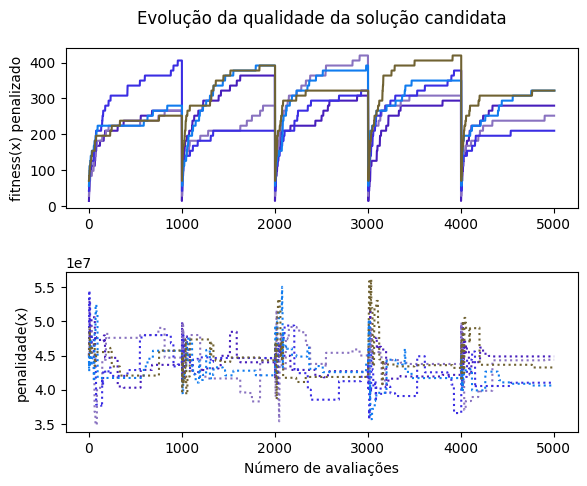

In [211]:
fig, (ax1, ax2) = plt.subplots(2, 1)
cores_historico = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(numero_de_execucoes)]
index_historico = 0
for historico in historicos_de_solucoes:
    s = len(historico.fit_pen)
    ax1.plot(np.linspace(0,s-1,s),historico.fit_pen,'k-', color=cores_historico[index_historico])
    ax2.plot(np.linspace(0,s-1,s),historico.pen,'b:', color=cores_historico[index_historico])
    index_historico += 1
    
fig.suptitle('Evolução da qualidade da solução candidata')
ax1.set_ylabel('fitness(x) penalizado')
ax2.set_ylabel('penalidade(x)')
ax2.set_xlabel('Número de avaliações')
plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

#### Plot Resultados Min PAs

In [212]:
def plot_triangulo(x, y, size, color):
    plt.plot(x, y, marker='^', markersize=size, color=color, linestyle='None')

# Função para plotar um círculo
def plot_circulo(x, y, size, color):
    plt.plot(x, y, marker='o', markersize=size, color=color, linestyle='None')
    

for x in melhores_solucoes:
    print(x.sol_PAs_ativos.keys())
    # Gerar uma lista de cores aleatórias para os pontos de acesso
    cores_pontos_acesso = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(len(x.sol_PAs_ativos))]

    cores: Dict[int, str] = {}

    index = 0
    for ponto_de_acesso_id in x.nCL_por_PA:
        cores[ponto_de_acesso_id] = cores_pontos_acesso[index]
        index += 1

    pontos_de_acessos_ativos: Dict[int, float] = {}
        
    for cliente_id, ponto_de_acesso_id in x.sol_PA_id_por_cliente.items():
        if ponto_de_acesso_id != INVALID:
            plot_triangulo(dados.PA_list[ponto_de_acesso_id].x, dados.PA_list[ponto_de_acesso_id].y, 10, color = cores[ponto_de_acesso_id])
            plot_circulo(dados.CL_list[cliente_id].x, dados.CL_list[cliente_id].y, 5, color = cores[ponto_de_acesso_id])

    # Configurar o gráfico
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    label = f'Número de PAs {x.fitness_PA_min} Clientes Atendidos {x.porcentagem_CL_antendidos}'
    plt.title(f'Pontos de Acesso e Clientes Atendidos \n{label}')
    plt.grid(True)

    # Mostrar o gráfico
    plt.show()


dict_keys([495, 990, 2475, 3513, 5128, 6337, 2932, 3387, 1849, 1576, 3637, 1551, 4669, 6362])


IndexError: list index out of range

#### Execução Min Dist

In [ ]:
numero_de_execucoes = 0
melhores_solucoes: List[Solucao] = []
historicos_de_solucoes: List[Struct] = []

while numero_de_execucoes < 5:
    print("Starting\n")
    melhor_solucao, historico = BVNS_minDist(solucao_inicial, dados)
    print(f'execução = {numero_de_execucoes} PAs = {melhor_solucao.fitness_PA_min} Porcentagem de Clientes Atendidos = {melhor_solucao.porcentagem_CL_antendidos} penalização = {melhor_solucao.fitness_PA_min_penalizado}')
    historicos_de_solucoes.append(historico)
    melhores_solucoes.append(melhor_solucao)
    numero_de_execucoes += 1

#### Plot Evolução das soluções Min Dist

#### Plot Resultados Min Dist